In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats

<h1> Research Questions </h1>

In [3]:
def normalize_data(data_input, normalizer, data_output, df):
    df[data_output] = df[data_input]/df[normalizer]*60

In [4]:
def create_focusDF(data):
    
    percentage_goals = []
    goals_achieved = []
    goals_set = []
    broken_Focus = []
    brokenFocus_number = []
    distraction_count = []
    distraction_time = []
    nr_of_services = []
    messages_received_in_focus = []
    
    # transform json part to pandas dataframe
    df = pd.json_normalize(data["focusSessions"])
    
    # create new column, which calculates how long a user stayed in focus
    df["minutesInFocus"] = round((df["endTime"] - df["startTime"])/60000,2)
    
    #df["distractionCount"] = 0

    
    for index, row in df.iterrows():
        # calculate percentage of achieved goals
        if len(row['goals']) == 0:
            percentage_goals.append(0)
            goals_set.append(0)
            goals_achieved.append(0)
        else:
            percentage_goals.append(round(len(row['completedGoals'])/len(row['goals']),2))
            goals_set.append(len(row['goals']))
            goals_achieved.append(len(row['completedGoals']))
        
        # calculate broken focus length
        if len(row["brokenFocus"]) == 0:
            broken_Focus.append(0)
            brokenFocus_number.append(0)
        else:
            break_per_focus= 0
            nr_of_breaks = 0
            for element in row["brokenFocus"]:
                if len(element) ==2:
                    break_per_focus += ((element[1]-element[0])/60000)
                    nr_of_breaks +=1
            broken_Focus.append(round(break_per_focus,2))
            brokenFocus_number.append(nr_of_breaks)
            
        # get distractionCount
        if len(row["activeWindows"]) == 0:
            distraction_count.append(0)
            distraction_time.append(0)
        else:
            distractionCountPerFocus = 0
            distractionTime = 0
            for index, element in enumerate(row["activeWindows"]):
                if element["isDistraction"]:
                    distractionCountPerFocus += 1
                    if index < len(row["activeWindows"])-1:
                        #print(index, len(row["activeWindows"]))
                        duration = row["activeWindows"][index+1]["timestamp"] - element["timestamp"]
                    else:
                        #print(row["endTime"])
                        duration = row["endTime"] - element["timestamp"]
                    distractionTime += (duration/60000)
            distraction_count.append(distractionCountPerFocus)
            distraction_time.append(distractionTime)
        
        # get number of used services
        nr_of_services.append(len(row["services"]))
        
        messages_received = 0
        for element in row["services"]:
            # get number of received messages
            messages_received += len(element["messages"])
        messages_received_in_focus.append(messages_received)
            
    
    df["distractionCount"] = distraction_count
    df["distractionTime"] = distraction_time
    df["numberOfServices"] = nr_of_services
    df["messages_received_in_focus"] = messages_received_in_focus 
    df["brokenFocus"] = broken_Focus
    df["nrOfBreaks"] = brokenFocus_number    
    df["percentageCompletedGoals"] = percentage_goals
    df["goalsAchieved"] = goals_achieved
    df["goalsSet"] = goals_set
    
    
    
    # drop columns startTime, endTime, originalEndTime, goals and completedGoals
    df = df.drop(["id","services","calendarSubject",'startTime', 'endTime','originalEndTime','goals','completedGoals',"activeWindows","comments"], axis=1)
    return df

In [5]:
from os import listdir
from os.path import isfile, join

mypath = "./data"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

df = pd.DataFrame()

for i in onlyfiles:
    with open(f'data/{i}', 'r') as outfile:
        data = json.load(outfile)
        df_temp = create_focusDF(data)
        df = pd.concat([df,df_temp])

df = df.reset_index()

In [6]:
test = df[(df["minutesInFocus"] > 300) |
           (df['minutesInFocus']<10)]

In [7]:
# outliers
len(test)

24

In [8]:
df

,index,brokenFocus,rating,scheduled,appVersion,minutesInFocus,distractionCount,distractionTime,numberOfServices,messages_received_in_focus,nrOfBreaks,percentageCompletedGoals,goalsAchieved,goalsSet
0,0,0.00,6,False,exman,40.00,0,0.0,2,1,0,0.62,5,8
1,1,1.23,4,False,exman,25.00,0,0.0,2,0,1,0.33,1,3
2,2,0.00,None,False,exman,55.00,0,0.0,2,0,0,1.00,4,4
3,3,0.00,5,False,exman,15.00,0,0.0,2,1,0,0.00,0,1
4,4,0.00,5,False,exman,35.00,0,0.0,3,0,0,0.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,12,0.00,7,False,exman,120.00,0,0.0,4,4,0,0.50,1,2
247,13,0.00,7,False,exman,30.00,0,0.0,4,0,0,1.00,1,1
248,14,0.00,4,False,exman,90.00,0,0.0,4,0,0,0.50,1,2
249,15,1.62,7,False,exman,107.61,0,0.0,4,1,3,1.00,2,2


<h2>What is the effect of notification blocking and distraction discouragements during a user defined time period on their perceived productivity?</h2>


In [9]:
# focus session which were longer than 6 hours were dropped (2 datapoints, probably participant forgot to close 
# focus session)

pomodoro = df[(df['appVersion'] == "pomodoro") & 
              (df["minutesInFocus"] < 300) &
              (df['minutesInFocus']>10)]
exman = df[(df['appVersion'] == "exman") & 
           (df["minutesInFocus"] < 300) & 
           (df['minutesInFocus']>10)]

In [10]:
exman

,index,brokenFocus,rating,scheduled,appVersion,minutesInFocus,distractionCount,distractionTime,numberOfServices,messages_received_in_focus,nrOfBreaks,percentageCompletedGoals,goalsAchieved,goalsSet
0,0,0.00,6,False,exman,40.00,0,0.0,2,1,0,0.62,5,8
1,1,1.23,4,False,exman,25.00,0,0.0,2,0,1,0.33,1,3
2,2,0.00,None,False,exman,55.00,0,0.0,2,0,0,1.00,4,4
3,3,0.00,5,False,exman,15.00,0,0.0,2,1,0,0.00,0,1
4,4,0.00,5,False,exman,35.00,0,0.0,3,0,0,0.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,12,0.00,7,False,exman,120.00,0,0.0,4,4,0,0.50,1,2
247,13,0.00,7,False,exman,30.00,0,0.0,4,0,0,1.00,1,1
248,14,0.00,4,False,exman,90.00,0,0.0,4,0,0,0.50,1,2
249,15,1.62,7,False,exman,107.61,0,0.0,4,1,3,1.00,2,2


In [11]:
pomodoro

,index,brokenFocus,rating,scheduled,appVersion,minutesInFocus,distractionCount,distractionTime,numberOfServices,messages_received_in_focus,nrOfBreaks,percentageCompletedGoals,goalsAchieved,goalsSet
18,18,0.0,None,False,pomodoro,25.00,0,0.0,3,1,0,1.00,2,2
19,19,0.0,6,False,pomodoro,25.00,0,0.0,3,0,0,1.00,2,2
20,20,0.0,None,False,pomodoro,110.91,0,0.0,3,16,0,1.00,3,3
21,21,0.0,4,False,pomodoro,40.00,0,0.0,3,0,0,0.00,0,4
22,22,0.0,6,False,pomodoro,25.00,0,0.0,3,0,0,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,5,0.0,5,False,pomodoro,30.00,0,0.0,4,0,0,1.00,1,1
240,6,0.0,5,False,pomodoro,57.82,0,0.0,4,0,0,0.50,1,2
241,7,0.0,6,False,pomodoro,120.00,0,0.0,4,6,0,0.67,2,3
242,8,0.0,5,False,pomodoro,60.00,0,0.0,4,2,0,0.00,0,1


<h4>goals achieved</h4>

In [12]:
normalize_data("goalsAchieved","minutesInFocus","goalsAchievedPerHour", exman)
normalize_data("goalsAchieved","minutesInFocus","goalsAchievedPerHour", pomodoro)

In [13]:
exman["goalsAchievedPerHour"].mean()

1.833449752093778

In [14]:
pomodoro["goalsAchievedPerHour"].mean()

1.3436390497595048

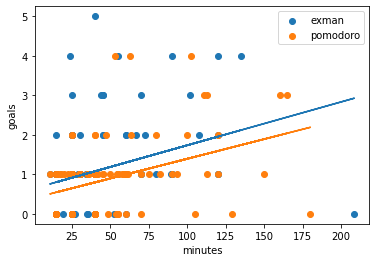

In [15]:
plt.scatter(exman["minutesInFocus"],exman["goalsAchieved"],label="exman")
plt.scatter(pomodoro["minutesInFocus"],pomodoro["goalsAchieved"], label="pomodoro")
plt.legend()

slope, intercept, r, p, stderr = scipy.stats.linregress(exman["minutesInFocus"], exman["goalsAchieved"])
plt.plot(exman["minutesInFocus"], intercept + slope * exman["minutesInFocus"])

slope, intercept, r, p, stderr = scipy.stats.linregress(pomodoro["minutesInFocus"], pomodoro["goalsAchieved"])
plt.plot(pomodoro["minutesInFocus"], intercept + slope * pomodoro["minutesInFocus"])

plt.xlabel("minutes")
plt.ylabel("goals")

plt.show()

In [16]:
from scipy import stats
tStat, pValue = stats.ttest_ind(exman["goalsAchievedPerHour"], pomodoro["goalsAchievedPerHour"], equal_var = False)
print("P-Value:{0} T-Statistic:{1}".format(pValue,tStat))

P-Value:0.02587229862116291 T-Statistic:2.2438752466987286


The p-value is significant. Therefore, the user was more effective using our app exman than using the pomodoro timer.

<h4> broken Focus per hours </h4>

In [17]:
normalize_data("brokenFocus","minutesInFocus","brokenFocusPerHour", exman)
normalize_data("brokenFocus","minutesInFocus","brokenFocusPerHour", pomodoro)

In [18]:
exman["brokenFocusPerHour"].mean()

0.48784796354100374

In [19]:
pomodoro["brokenFocusPerHour"].mean()

3.0109144450290617

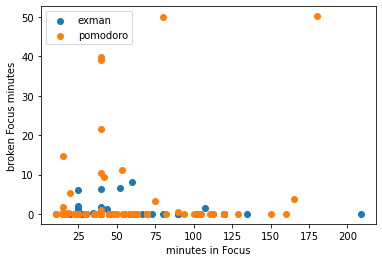

In [20]:
plt.scatter(exman["minutesInFocus"],exman["brokenFocus"],label="exman")
plt.scatter(pomodoro["minutesInFocus"],pomodoro["brokenFocus"], label="pomodoro")
plt.xlabel("minutes in Focus")
plt.ylabel("broken Focus minutes")
plt.legend()

In [21]:
from scipy import stats
tStat, pValue = stats.ttest_ind(exman["brokenFocusPerHour"], pomodoro["brokenFocusPerHour"], equal_var = False)
print("P-Value:{0} T-Statistic:{1}".format(pValue,tStat))

P-Value:0.01711207312732622 T-Statistic:-2.418464796263217


<h4> broken focus frequency </h4>

In [22]:
normalize_data("nrOfBreaks","minutesInFocus","brokenFrequencyPerHour", exman)
normalize_data("nrOfBreaks","minutesInFocus","brokenFrequencyPerHour", pomodoro)

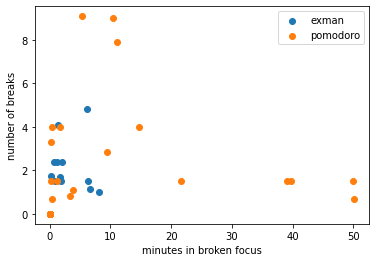

In [23]:
plt.scatter(exman["brokenFocus"],exman["brokenFrequencyPerHour"],label="exman")
plt.scatter(pomodoro["brokenFocus"],pomodoro["brokenFrequencyPerHour"], label="pomodoro")
plt.xlabel("minutes in broken focus")
plt.ylabel("number of breaks")
plt.legend()

In [24]:
exman["brokenFrequencyPerHour"].mean()

0.22747864168793977

In [25]:
pomodoro["brokenFrequencyPerHour"].mean()

0.5029443694609202

In [26]:
from scipy import stats
tStat, pValue = stats.ttest_ind(exman["brokenFrequencyPerHour"], pomodoro["brokenFrequencyPerHour"], equal_var = False)
print("P-Value:{0} T-Statistic:{1}".format(pValue,tStat))

P-Value:0.09920070251431919 T-Statistic:-1.658472812049136


The effect on frequency of breaks is not significant, but the difference of the break duration between pomodoro and exman is significant on a 5% level. Reason for that not known yet.

<h4>distraction time </h4>

In [27]:
normalize_data("distractionTime","minutesInFocus","distractionTimePerHour",exman)
normalize_data("distractionTime","minutesInFocus","distractionTimePerHour",pomodoro)

In [28]:
max(exman["distractionTime"])

11.20925

In [29]:
exman["distractionTimePerHour"].mean()

1.733884165806526

In [30]:
pomodoro["distractionTimePerHour"].mean()

2.0561815823129317

In [31]:
from scipy import stats
tStat, pValue = stats.ttest_ind(exman["distractionTimePerHour"], pomodoro["distractionTimePerHour"], equal_var = False)
print("P-Value:{0} T-Statistic:{1}".format(pValue,tStat))

P-Value:0.7316975137945269 T-Statistic:-0.3433181976946759


Not significant

<h4>Summary page rating</h4>

In [32]:
exman["rating"].dropna().astype(int).mean()

5.885714285714286

In [33]:
pomodoro["rating"].dropna().astype(int).mean()

5.74

<h4> Productivity Rating </h4>

In [34]:
exman = exman.dropna(subset=["rating"])
pomodoro = pomodoro.dropna(subset=["rating"])

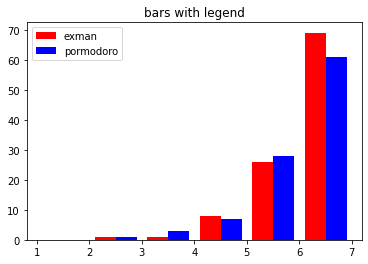

In [35]:
bins = [1,2,3,4,5,6,7]
x = [list(exman["rating"].astype(int)),list(pomodoro["rating"].astype(int))]

label = ["exman","pormodoro"]
colors = ['red', 'blue']
plt.hist(x, bins, histtype='bar', color=colors, label=label)
plt.legend(prop={'size': 10})
plt.title('bars with legend')


plt.show()

In [36]:
from scipy import stats
tStat, pValue = stats.ttest_ind(exman["rating"].astype(int), pomodoro["rating"].astype(int), equal_var = False)
print("P-Value:{0} T-Statistic:{1}".format(pValue,tStat))

P-Value:0.3389466734031623 T-Statistic:0.9585245074826414


The p-Value and the t-test is not significant. Therefore, we cannot assume, that exman provides an improvement of the productivity compared to the pomodoro baseline.